$\Huge{\text{Modelisation du cours du BITCOIN}}$

<hr><b>
<hr><b>

$\huge{\text{Groupe KAGLAN KHABIE KHENESSI}}$

# Imports and set up

Remarque : Le module arch est appellé dans les imports. Il faudra l'installer avec la commande !pip install arch 

In [1]:
import os
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.collections import PolyCollection
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from arch.unitroot import ADF
import pmdarima as pmd
plt.rcParams['figure.figsize']=(10,8)
plt.rc('axes', labelsize = 15)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.style.use('seaborn-whitegrid')

# Récupération des données

Cours de Cloture du BITCOIN sur 10 ans (du 06-12-2011 au 23-12-2021 )

In [207]:
!wget https://minio.lab.sspcloud.fr/mawulikaglan/BTCUSD_10AN.txt
!ls

--2022-01-06 11:35:37--  https://minio.lab.sspcloud.fr/mawulikaglan/BTCUSD_10AN.txt
Resolving minio.lab.sspcloud.fr (minio.lab.sspcloud.fr)... 192.168.253.152, 192.168.253.151
Connecting to minio.lab.sspcloud.fr (minio.lab.sspcloud.fr)|192.168.253.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180782 (177K) [binary/octet-stream]
Saving to: ‘BTCUSD_10AN.txt’

BTCUSD_10AN.txt     100%[===================>] 176.54K  --.-KB/s    in 0.003s  

2022-01-06 11:35:37 (57.1 MB/s) - ‘BTCUSD_10AN.txt’ saved [180782/180782]

 BTCUSD_10AN.txt
 BTCUSD.txt
'Charles-Travail de modelisation .ipynb'
'Notebook DataScience Project - Webscrapping.ipynb'
'Notebook Webscrapping using Selenium - Final.ipynb'
 Untitled.ipynb


## Importation des données :

In [240]:
BTC = pd.read_csv('BTCUSD_10AN.txt', sep="\t", parse_dates=[0], index_col=0)

In [210]:
for x in BTC:
    print(x)

ouv
haut
bas
clot
vol
devise
Unnamed: 7


In [241]:
BTC=BTC['2020-01-01':].copy()

In [242]:
Close = BTC['clot']

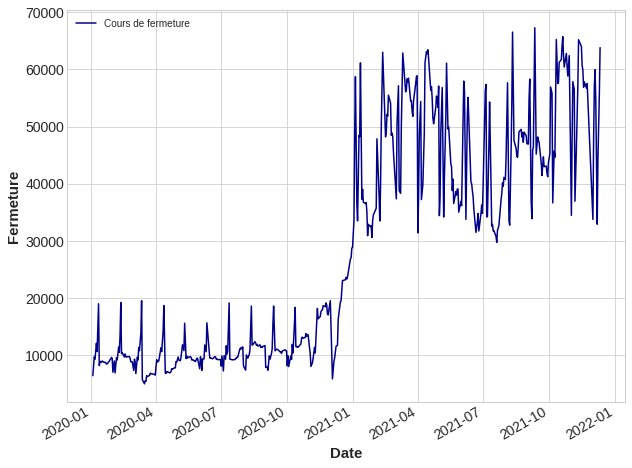

In [243]:
Close.plot(color='darkblue', label='Cours de fermeture')
plt.ylabel('Fermeture', fontdict={'weight':'bold'})
plt.xlabel('Date',fontdict={'weight':'bold'})
plt.legend()

## Serie des log-returns

In [244]:
logrets=Close.pct_change().apply(lambda x: np.log(1 + x)).dropna()

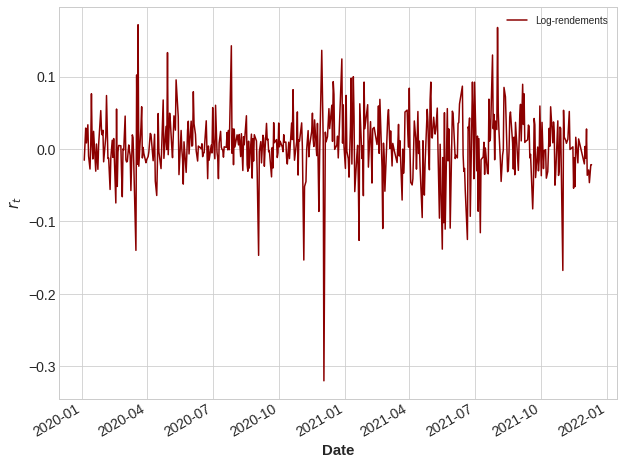

In [245]:
logrets.plot(color='darkred', label='Log-rendements')
plt.ylabel(r'$r_t$', fontdict={'weight':'bold'})
plt.xlabel('Date',fontdict={'weight':'bold'})
plt.legend()

## Analyse des données

 ### Statistiques descriptives

#### Observation de la queue et de la tête des données de log-rendements

In [215]:
lrets_train = logrets.copy()
lrets_train.tail(), lrets_train.head()

(date
 2021-11-17   -0.012077
 2021-11-18   -0.051807
 2021-11-19    0.016305
 2021-11-22   -0.019078
 2021-11-23    0.014019
 Name: clot, dtype: float64,
 date
 2012-07-01    0.125163
 2012-08-01    0.028988
 2012-09-01   -0.105361
 2012-10-01    0.125163
 2012-11-01   -0.019803
 Name: clot, dtype: float64)

#### Statistiques descriptives

In [216]:
lrets_train.describe()

count    3217.000000
mean        0.002850
std         0.048100
min        -0.663948
25%        -0.013057
50%         0.002381
75%         0.020785
max         0.337486
Name: clot, dtype: float64

In [217]:
Sk = stats.skew
K = stats.kurtosis

In [218]:
Sk(lrets_train), K(lrets_train), K(lrets_train)-3

(-1.192252507939448, 18.671469084201036, 15.671469084201036)

Commentaire :

### Préliminaires à la modelisation

#### Etude de la Normalité des log-returns

In [80]:
stats.shapiro(lrets_train)

ShapiroResult(statistic=0.9308215975761414, pvalue=1.4776571080014206e-14)

In [81]:
stats.jarque_bera(lrets_train)

Jarque_beraResult(statistic=892.0135340163886, pvalue=0.0)

In [82]:
stats.kstest(lrets_train, 'norm')

KstestResult(statistic=0.44542023071857895, pvalue=3.23594432272239e-92)

#### Fonction de densité empirique de la série des log-returns (KDE)

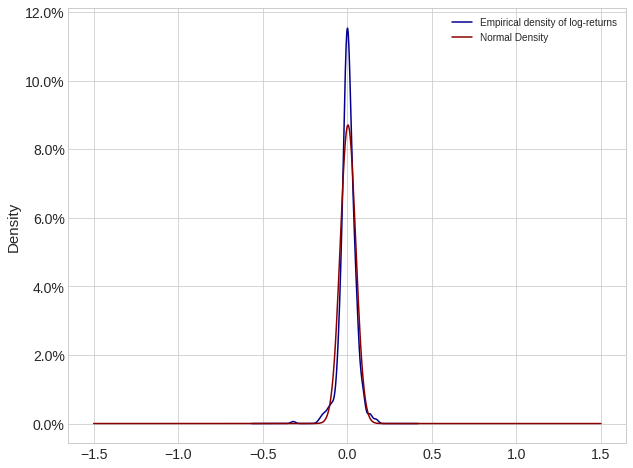

In [83]:
lrets_train.plot(kind='kde', color='darkblue', label='Empirical density of log-returns')
plt.yticks(plt.yticks()[0],[str(x)+'%' for x in plt.yticks()[0]])
x=np.linspace(-1.5, 1.5, len(lrets_train))
plt.plot(x, stats.norm.pdf(x, lrets_train.mean(), lrets_train.std()), color='darkred', label='Normal Density')
plt.legend()

#### Fonction de répartition empirique de la série de log returns

In [84]:
p = stats.norm.fit(lrets_train)

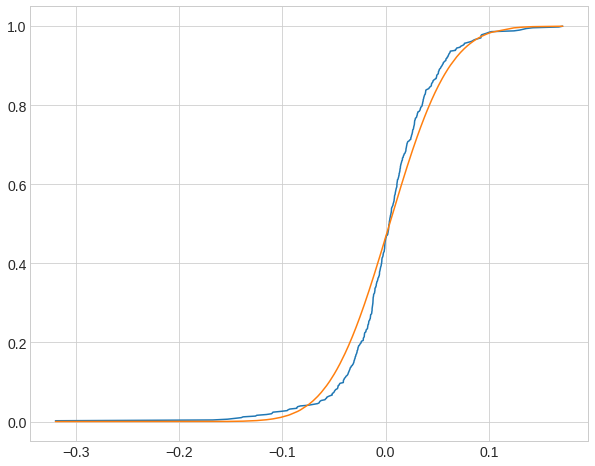

In [85]:
from statsmodels.distributions.empirical_distribution import ECDF
ecdf = ECDF(lrets_train)
x = ecdf.x
plt.plot(x, ecdf.y)
plt.plot(x, stats.norm.cdf(x, *p))

#### Diagrams QQ-plot of log-returns

(-4.0, 4.0)

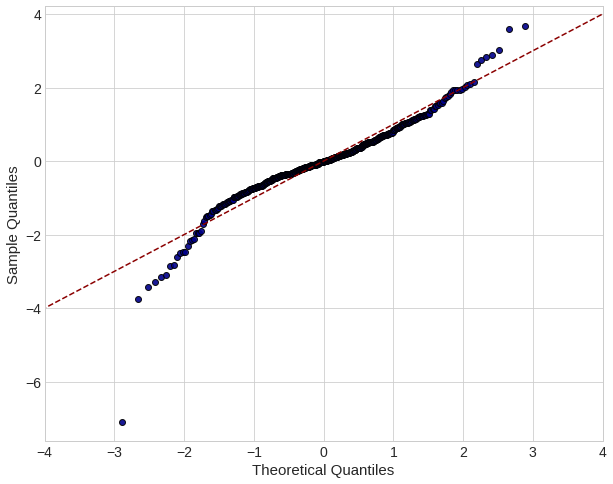

In [86]:
import statsmodels.api as sm
pp = sm.ProbPlot(lrets_train, fit=True)
qq = pp.qqplot(marker='o', markerfacecolor='darkblue', markeredgecolor='k', alpha=0.9)
sm.qqline(qq.axes[0], line='45', color='darkred', linestyle='dashed')
plt.xlim((-4,4))

#### Analyse de la stationarité : Test des Dickey-Fuller Augmenté (ADF-Augmented Dickey-Fuller Test)

##### Remarque : Il faut ici avoir d'abord installé le module arch avec la commande !pip install arch 

In [87]:
from arch.unitroot import ADF
trends = ['ct', 'c', 'n' ]
for t in trends:
    r=ADF(lrets_train, trend=t)
    print(r,'\n')

   Augmented Dickey-Fuller Results   
Test Statistic                 -7.902
P-value                         0.000
Lags                                6
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.98 (1%), -3.42 (5%), -3.13 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 

   Augmented Dickey-Fuller Results   
Test Statistic                 -7.906
P-value                         0.000
Lags                                6
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 

   Augmented Dickey-Fuller Results   
Test Statistic                 -7.737
P-value                         0.000
Lags                                6
-------------------------------------

Trend: No Trend
Critical Values: -2.57 (1%), 

Commentaire: 

#### Fonction d'autocorrélation partiel et Fonction d'autocorrélation (ACF /PACF )

In [18]:
def AcfPacf(data, model=''):
    fig, ax = plt.subplots(2)
    smt.graphics.plot_acf(data, ax=ax[0], color='darkblue', vlines_kwargs={'linewidth':3,'color':'darkblue'});
    smt.graphics.plot_pacf(data, ax=ax[1], color='darkblue', vlines_kwargs={'linewidth':3,'color':'darkblue'});
    for item, itemm in zip(ax[0].collections, ax[1].collections):
        if ((type(item)==PolyCollection) & (type(itemm)==PolyCollection)) :
            item.set_facecolor('darkred')
            itemm.set_facecolor('darkred')
    ax[0].set_title('ACF' +model,fontdict={'weight':'bold'})
    ax[1].set_title('PACF' +model,fontdict={'weight':'bold'})
    return None

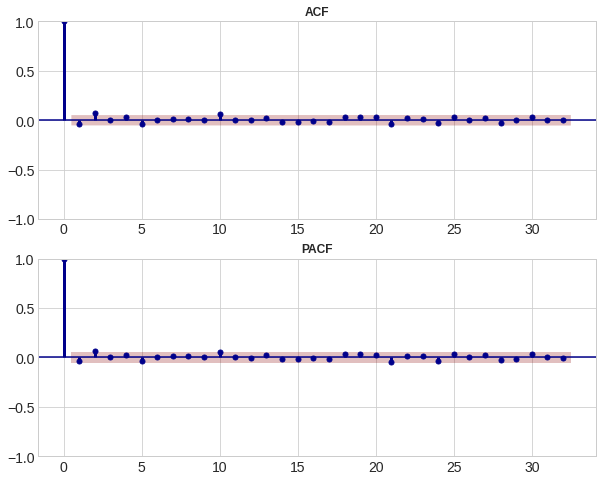

In [61]:
AcfPacf(lrets_train)

##### Commentaire : 
On remarque dans l’ACF que presque la majorité des autocorrélations, à l’exception de uelues unes comme la première, la troisième et la cinuième sont nulles au risque d’erreur de 5%. Le même constat s’applique
au PACF. 
Ce résultat est très connu dans les marchés financiers liquides et est souvent cité comme un
argument ”empirique” de l’hypothèse d’efficience des marchés financiers. 

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


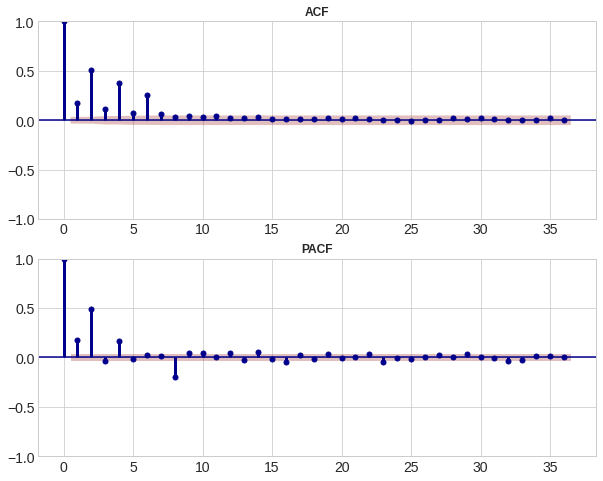

In [43]:
AcfPacf((lrets_train)**2)

##### Interprétation : 
Considérant maintenant, l’ACF et le PACF de la série des carrés des log-rendements, on remarque que les carrés des
log-rendements exhibent des autocorrélations significativement non nulles, jusqu’à l’ordre 7 ! Et les autaucorrélations patielles significativement non nulles, jusqu’à l’ordre 5.

#### Lag-plots et intérêts à la prédiction

50  : ( -0.3201 , -0.0204  )
------------------------------
51  : ( -0.0204 , -0.1399  )
------------------------------
52  : ( -0.1399 , 0.1024  )
------------------------------
53  : ( 0.1024 , -0.0210  )
------------------------------
54  : ( -0.0210 , 0.1717  )
------------------------------
55  : ( 0.1717 , -0.0237  )
------------------------------


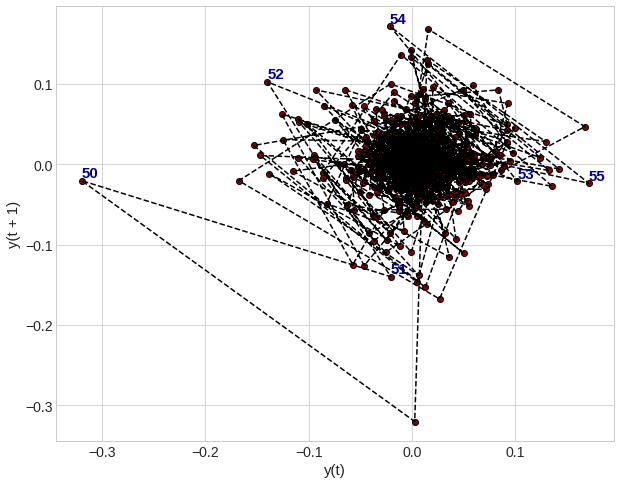

In [96]:
plt.rcParams['patch.facecolor']='darkred'
plt.plot(lrets_train.shift(1), lrets_train,'k--')
pd.plotting.lag_plot(lrets_train, 1, edgecolor='black')
for i in range(50,56):
    plt.annotate(str(i), (lrets_train.shift(1)[i], lrets_train[i]+0.004),fontweight='bold',fontsize=15, color='darkblue')
    print(str(i),' : ( %.4f' % lrets_train.shift(1)[i],', %.4f ' %lrets_train[i],')\n------------------------------')

# Modelisation et Prevision (Forecasting)

## Modèle linéaire ARIMA : 

### Estimation des parametres du Modèle ARIMA

In [246]:
for p in range(1,3):
    for q in range(1,3):
        mdl=smt.ARIMA(lrets_train, order=(p,0,q), trend='c').fit()
        res=mdl.resid
        lj=sm.stats.diagnostic.acorr_ljungbox(res, lags=[4], model_df=p+q,return_df=True)
        pv=lj.values[0][1]
        print('model : ARIMA (',p,',0,',q,')', 'AIC : ',np.round(mdl.aic,4),'p-value : ',np.round(pv, 4))

model : ARIMA ( 1 ,0, 1 ) AIC :  -10390.6259 p-value :  0.3099
model : ARIMA ( 1 ,0, 2 ) AIC :  -10389.9538 p-value :  0.0708
model : ARIMA ( 2 ,0, 1 ) AIC :  -10388.2448 p-value :  0.0845
model : ARIMA ( 2 ,0, 2 ) AIC :  -10386.2308 p-value :  nan


In [104]:
lj.values[0][1]

0.03893814896438679

### Estimation des résidus du model

In [220]:
import pmdarima as pmd

In [221]:
mean_mdl=pmd.auto_arima(lrets_train, start_q=0, start_p=0)

In [222]:
mean_mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3217
Model:               SARIMAX(1, 0, 0)   Log Likelihood                5199.016
Date:                Thu, 06 Jan 2022   AIC                         -10392.033
Time:                        11:41:52   BIC                         -10373.804
Sample:                             0   HQIC                        -10385.499
                               - 3217                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0029      0.001      3.311      0.001       0.001       0.005
ar.L1         -0.0290      0.007     -4.289      0.000      -0.042      -0.016
sigma2         0.0023   1.97e-05    117.226      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             50664.90
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                            -1.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [147]:
residuals = pd.Series(mean_mdl.resid(), index=lrets_train.index)

In [148]:
#stats.shapiro(residuals)
stats.kstest(residuals, 'norm')

KstestResult(statistic=0.44697513191729465, pvalue=6.824319241551754e-93)

#### Interprétation: 
On a une p-value>5% alors on ne rejette pas l'hypothèse Ho selon laquelle les résidus suivent une loi normale. 

## Modèle GARCH

### Test de la Validité du Modèle: 

In [223]:
from statsmodels.stats.diagnostic import het_arch

In [229]:
test_arch=het_arch(residuals, nlags=1)
name=["LM","LM p-value", "F", "F p-value"]
res_arch=pd.Series(test_arch, index=name)
res_arch

LM            0.602409
LM p-value    0.437660
F             0.600743
F p-value     0.438658
dtype: float64

### Modèle GARCH pour les résidus

In [151]:
from arch.univariate import arch_model
var_model=arch_model(residuals, mean = 'Zero', vol="GARCH", rescale=True, dist='StudentsT').fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 7581.794634315187
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1054.488642859603
Iteration:      3,   Func. Count:     19,   Neg. LLF: 631.7228946864985
Iteration:      4,   Func. Count:     25,   Neg. LLF: 288.1231300660731
Iteration:      5,   Func. Count:     31,   Neg. LLF: 608.9729224329274
Iteration:      6,   Func. Count:     37,   Neg. LLF: 262.3183173512466
Iteration:      7,   Func. Count:     42,   Neg. LLF: 579.3974961735908
Iteration:      8,   Func. Count:     48,   Neg. LLF: 673.7282267226085
Iteration:      9,   Func. Count:     55,   Neg. LLF: 261.40598448043005
Iteration:     10,   Func. Count:     61,   Neg. LLF: 263.4462330323333
Iteration:     11,   Func. Count:     67,   Neg. LLF: 260.46890441015455
Iteration:     12,   Func. Count:     72,   Neg. LLF: 260.4187296323179
Iteration:     13,   Func. Count:     77,   Neg. LLF: 260.41014101311777
Iteration:     14,   Func. Count:     82,   Neg. LLF: 260.407

In [153]:
var_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Zero Mean - GARCH Model Results                           
====================================================================================
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.002
Vol Model:                            GARCH   Log-Likelihood:               -260.407
Distribution:      Standardized Student's t   AIC:                           528.814
Method:                  Maximum Likelihood   BIC:                           545.728
                                              No. Observations:                  507
Date:                      Thu, Jan 06 2022   Df Residuals:                      507
Time:                              02:04:16   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.9350e-03  3.554e-03      1.388      0.165 [-2.031e-03,1.190e-02]
alpha[1]       0.0780  2.730e-02      2.858  4.268e-03    [2.451e-02,  0.132]
beta[1]        0.9104  1.967e-02     46.278      0.000      [  0.872,  0.949]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             3.4949      0.520      6.724  1.773e-11 [  2.476,  4.514]
========================================================================

Covariance estimator: robust
"""

## Estimation de la Volatilité sous le Modèle ARIMA(1,0,1)

In [117]:
class VolatilityEst:
    __Estimators__ = ['Rolling', 'EWMA', 'RogersSatchell', 'Parkinson', 'GarmanKlass']

    def __init__(self, data):
        self.data = data
        return None
    def printNames(self):
        return VolatilityEst.__Estimators__    

    def __getLret(self, close):
        return close.pct_change().apply(lambda x: np.log(1 + x)).dropna()

    def Estimate(self, window = 5, name = 'Rolling'):
        if (name == 'Rolling'):
            est = np.sqrt((self.__getLret(self.data['clot'])**2).rolling(window).mean())

        if(name == 'EWMA'):
            est = np.sqrt((self.__getLret(self.data['clot'])**2).ewm(alpha=1.-0.94).mean())
             

        if(name == 'RogersSatchell'):
            est = np.sqrt( (np.log(self.data['haut']/self.data['bas']) * np.log(self.data['haut']/self.data['clot']) + np.log(self.data['bas']/self.data['ouv']) * np.log(self.data['bas']/self.data['clot'])).rolling(window).mean())

        if(name == 'Parkinson'):
            est = np.sqrt(((0.25/np.log(2))*(np.log(self.data['haut']/self.data['bas']))**2).rolling(window).mean())

        if(name == 'GarmanKlass'):
            c = window/(window-1)
            est = np.sqrt((0.51*c*(np.log(self.data['haut']/self.data['bas']))**2 - 0.39*c*self.__getLret(self.data['clot'])**2).rolling(window).mean())

        return est[:'2021-12-31']

In [129]:
vol = VolatilityEst(BTC)

In [119]:
vol.printNames()

['Rolling', 'EWMA', 'RogersSatchell', 'Parkinson', 'GarmanKlass']

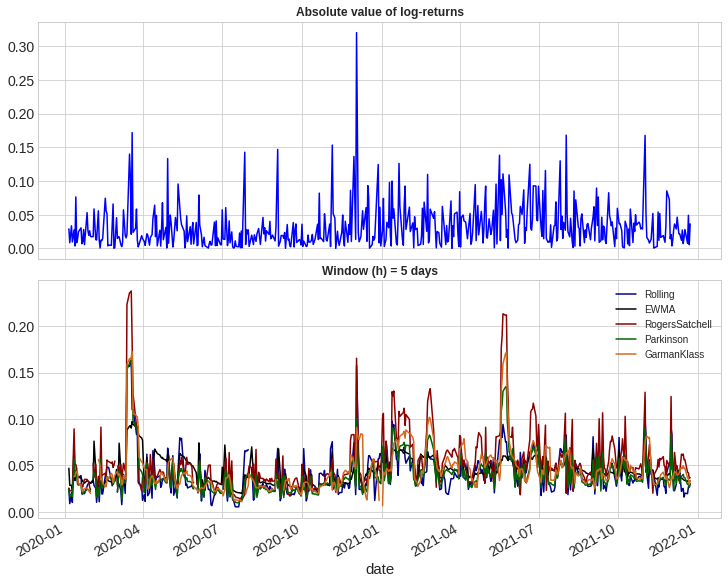

In [120]:
colors = ['darkblue', 'black', 'darkred', 'darkgreen', 'chocolate']
fig, axs = plt.subplots(2,1, constrained_layout=True, sharex=True)
lrets_train.apply(lambda x: np.abs(x)).plot(color='blue', ax=axs[0])
axs[0].set_title('Absolute value of log-returns', fontdict={'weight':'bold'})
for name, color in zip(vol.printNames(), colors):
    vol.Estimate(name=name).plot(label=name, color=color, ax=axs[1])
plt.title('Window (h) = 5 days', fontdict={'weight':'bold'})
plt.legend()

## La prévision par lissage exponentiel (Exponential smoothing )

In [97]:
ES = smt.ExponentialSmoothing
SES = smt.SimpleExpSmoothing


**(1-$\alpha$) Conf-int** : 

$[$ $z_{\alpha}$ : $\alpha$ quantile of the standard normal dist, $\beta$ : smoothing parameter ($\beta = 1-\gamma$ where $\gamma$ is the smoothing param in Python)$]$

- **SES** :  $ [ \ \hat{r}_t(h) - z_{1-\frac{\alpha}{2}}\ \sigma_r C(h, \beta),\  \hat{r}_t(h) + z_{1-\frac{\alpha}{2}}\ \sigma_r C(h, \beta) \  ]$ where : $$C^2(h, \beta)= 1 + \frac{1-\beta}{(1+\beta)^3} \left[(1+4\beta + 5\beta^2) + 2h(1-\beta)(1+3\beta) + 2h^2(1-\beta)^2 \right] $$

In [199]:
import warnings
warnings.filterwarnings('ignore')

class ExpSmooth:
    def __init__(self, data):
        self.data = data
        return None

    def __C(self, h, beta):
        return 1 + ((1-beta)/(1+beta**3))*(1+4*beta+5*beta**2 + 2*h*(1-beta)*(1+3*beta) + 2*(h**2)*(1-beta)**2)

    def __ConfInt(self, forecasts, beta,  method, horizon, alpha=.05):
        idx = forecasts.index[0]
        ci = []
        sigma = self.data.std()
        z = stats.norm.ppf(1-alpha/2)
        for h in range(horizon):
            ci.append([forecasts[idx + h]-z*sigma*np.sqrt(self.__C(h, beta)),forecasts[idx + h]+z*sigma*np.sqrt(self.__C(h, beta))])
        return pd.DataFrame(ci, columns=['down', 'up'])

    def SES(self, forecasts_horizon=1):
        ses_fit = SES(self.data, initialization_method='estimated').fit()
        ses_forecasts = ses_fit.forecast(forecasts_horizon).rename(r'$\beta = %s$'%np.round(1 - ses_fit.params['smoothing_level'], 3))
        beta = 1-ses_fit.params['smoothing_level']
        return ses_fit, ses_forecasts, self.__ConfInt(ses_forecasts, beta= beta, method='SES', horizon=forecasts_horizon)

In [200]:
es = ExpSmooth(lrets_train)

In [201]:
ses_fit, ses_forecasts, ses_ci = es.SES(forecasts_horizon=len(lrets_train))

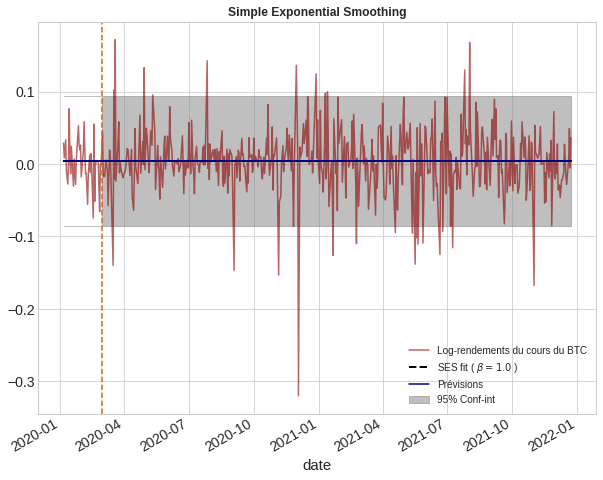

In [202]:
logrets.plot(color='darkred', alpha=0.6)
plt.plot(ses_fit.fittedvalues, color='black', linestyle='dashed', linewidth=2)
plt.plot(lrets_train.index, ses_forecasts, color='darkblue')
plt.fill_between(lrets_train.index, ses_ci['down'],ses_ci['up'], color='gray', alpha=0.5)
plt.title('Simple Exponential Smoothing', fontdict={'weight':'bold'})
plt.legend(['Log-rendements du cours du BTC','SES fit ( '+ ses_forecasts.name +' )', 'Prévisions','95% Conf-int'])
plt.axvline(x=lrets_train.index[0], linestyle='dashed', color='chocolate')

 ### Erreur de prédiction

In [204]:
def RMSE(data1, data2):
    n = len(data1)
    print('RMSE : ')
    return np.sqrt(((data2-data1)**2).sum()/n)

In [206]:
RMSE(ses_forecasts, lrets_train.values)

RMSE : 


0.04573869084766143